In [1]:
import lightgbm as lgb
import pandas as pd
import sklearn
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/finalMergedData.csv'
df = pd.read_csv(file_path)

# df = pd.read_csv("./finalMergedData.csv")
# Assuming your DataFrame is called df
df.columns

Mounted at /content/drive


Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'frameId',
       'playDirection', 'x', 'y', 'distanceToEndZone', 'height_x', 'weight_x',
       'collegeName', 'Full Name', 'Team', 'Position', 'yearsPro',
       'overall_rating', 'teamId', 'age'],
      dtype='object')

In [5]:
df.columns
columns = ['gameId','ballCarrierId','ballCarrierDisplayName','playDescription','passResult','passLength','penaltyYards','prePenaltyPlayResult','playNullifiedByPenalty',
           'homeTeamWinProbabilityAdded','visitorTeamWinProbilityAdded','expectedPointsAdded','foulNFLId1','foulNFLId2','frameId',
           'Full Name','teamId','foulName1','foulName2']
df = df.drop(columns=columns)

In [6]:
#this piece of data processing code is snipped from other people's kaggle notebook record.
#https://www.kaggle.com/code/mansooralam559/classification-model-for-nfl-big-data-bowl-2024
def convert_height_to_meters(height):
    # Split the height into feet and inches
    feet, inches = map(int, height.split('-'))
    # Convert height to inches
    total_inches = feet * 12 + inches
    # Convert inches to cm (1 inch = 2.54 cm)
    height_cm = total_inches * 2.54
    # Convert cm to meters
    height_m = height_cm / 100
    return height_m
df['height_x'] = df['height_x'].apply(convert_height_to_meters)

def gameClockConverter(clock):
    minutes,second = map(int,clock.split(':'))
    totalTime = minutes*60 + second
    return totalTime
df['gameClock'] = df['gameClock'].apply(gameClockConverter)

#the open source kaggle notebook also reminds me of calculating the bmi of a player. This could be essential because it gives a more intuitive
#and quantitative information about a player's physique.

In [7]:

df['yardlineSide'] = df['yardlineSide'].fillna('none')
df['offenseFormation']=df['offenseFormation'].fillna('none')
# deFendersIntheBoxMean = df['defendersInTheBox'].mean()
df['defendersInTheBox'] = df['defendersInTheBox'].fillna(df['defendersInTheBox'].mean())
df['passProbability'] = df['passProbability'].fillna(df['passProbability'].mean())

df.isna().sum()
# deFendersIntheBoxMean

playId                              0
quarter                             0
down                                0
yardsToGo                           0
possessionTeam                      0
defensiveTeam                       0
yardlineSide                        0
yardlineNumber                      0
gameClock                           0
preSnapHomeScore                    0
preSnapVisitorScore                 0
playResult                          0
absoluteYardlineNumber              0
offenseFormation                    0
defendersInTheBox                   0
passProbability                     0
preSnapHomeTeamWinProbability       0
preSnapVisitorTeamWinProbability    0
expectedPoints                      0
playDirection                       0
x                                   0
y                                   0
distanceToEndZone                   0
height_x                            0
weight_x                            0
collegeName                         0
Team        

In [8]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt

#EDA for corr heapmap
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'ATL'

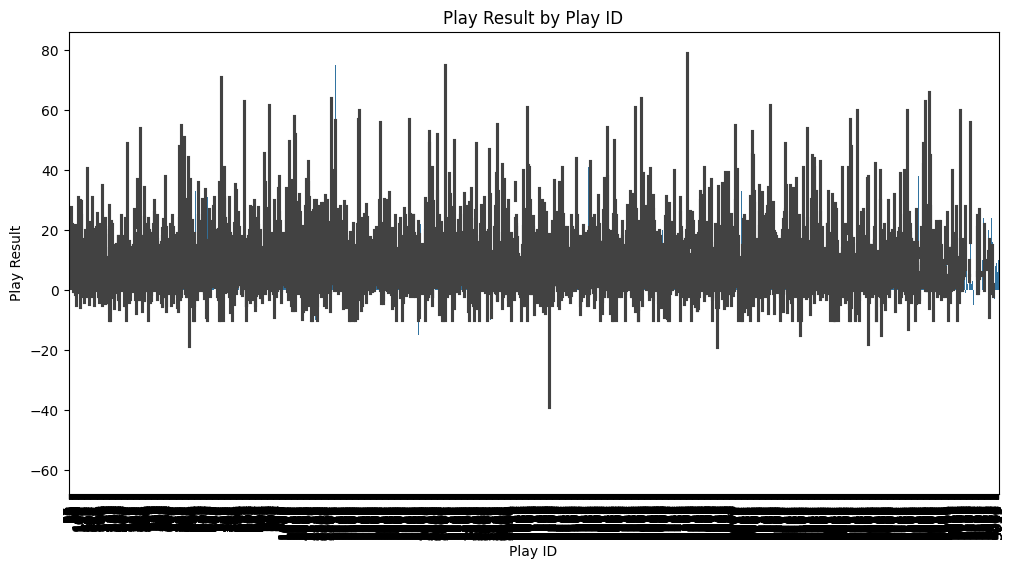

In [9]:
df['playId'] = df['playId'].astype('category')

# Plot barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='playId', y='playResult', data=df)
plt.title('Play Result by Play ID')
plt.xlabel('Play ID')
plt.ylabel('Play Result')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()



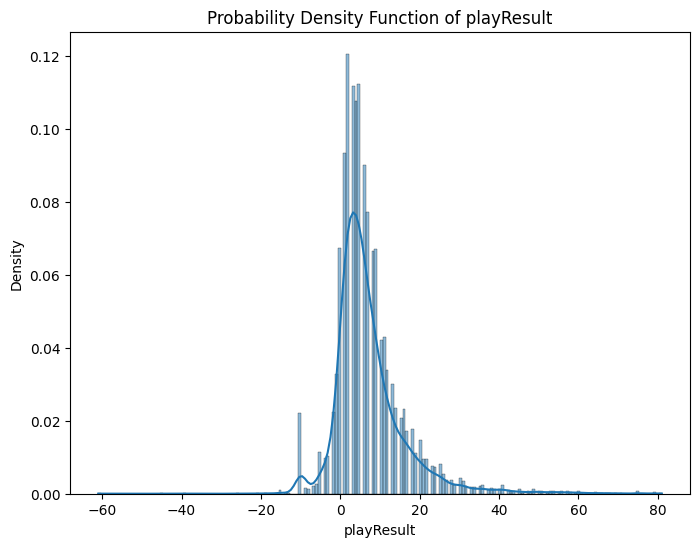

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(df['playResult'], kde=True, stat='density')
plt.title('Probability Density Function of playResult')
plt.xlabel('playResult')
plt.ylabel('Density')
plt.show()
#we can tell it is normally distributed

In [11]:
#scaling
from sklearn.preprocessing import StandardScaler

# Get list of numerical column names
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Remove playResult from numerical_cols
numerical_cols.remove('playResult')

# Separate numerical and categorical features
X_numerical = df[numerical_cols]  # Only include numerical columns
X_categorical = df.drop(columns=numerical_cols + ['playResult'])  # Exclude numerical and target columns

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize numerical features (excluding playResult)
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Convert the standardized numerical features back to a DataFrame
X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=X_numerical.columns)

# Concatenate the standardized numerical features with the categorical features and playResult column
df_standardized = pd.concat([X_numerical_scaled_df, X_categorical, df['playResult']], axis=1)

# Now df_standardized contains the entire dataset with numerical features standardized except for playResult
numerical_cols

['quarter',
 'down',
 'yardsToGo',
 'yardlineNumber',
 'gameClock',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'absoluteYardlineNumber',
 'defendersInTheBox',
 'passProbability',
 'preSnapHomeTeamWinProbability',
 'preSnapVisitorTeamWinProbability',
 'expectedPoints',
 'x',
 'y',
 'distanceToEndZone',
 'height_x',
 'weight_x',
 'yearsPro',
 'overall_rating',
 'age']

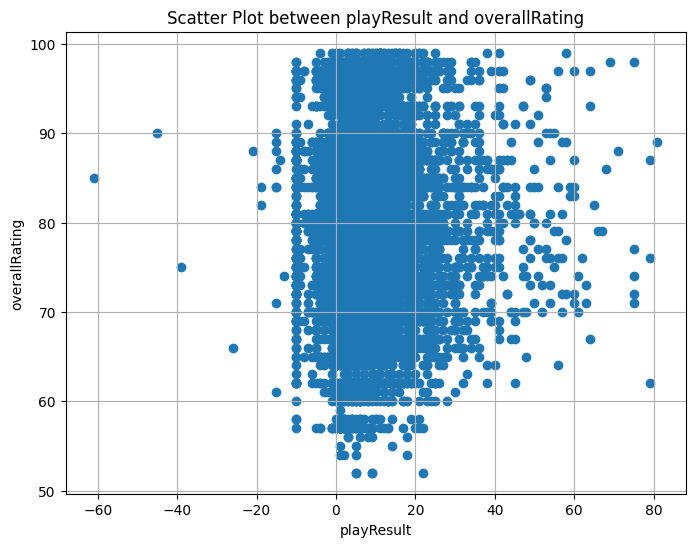

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df['playResult'], df['overall_rating'])
plt.title('Scatter Plot between playResult and overallRating')
plt.xlabel('playResult')
plt.ylabel('overallRating')
plt.grid(True)
plt.show()

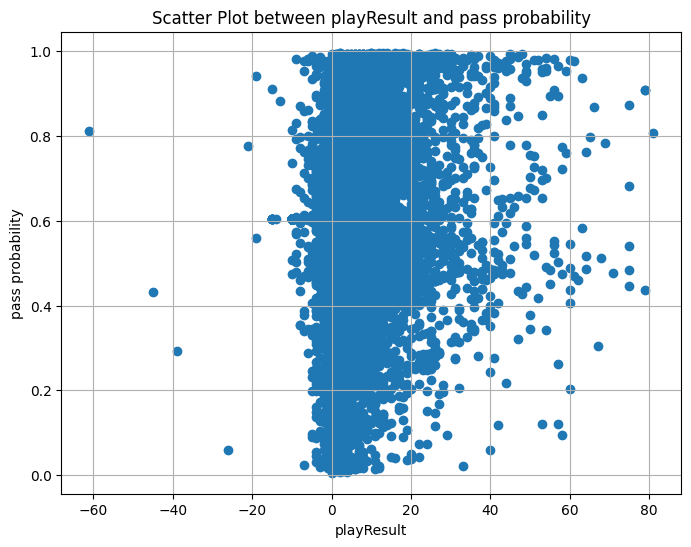

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(df['playResult'], df['passProbability'])
plt.title('Scatter Plot between playResult and pass probability')
plt.xlabel('playResult')
plt.ylabel('pass probability')
plt.grid(True)
plt.show()

In [14]:
df_standardized

,quarter,down,yardsToGo,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,defendersInTheBox,passProbability,...,playId,possessionTeam,defensiveTeam,yardlineSide,offenseFormation,playDirection,collegeName,Team,Position,playResult
0,1.274946,-0.918198,0.397173,0.915164,0.113727,1.025407,-0.315867,0.355879,0.570704,0.610491,...,3537,ATL,TB,ATL,SHOTGUN,left,Iowa,Falcons,TE,9
1,-1.361688,1.588349,-1.126446,0.995623,1.416317,-1.193672,-1.078588,-0.356596,-0.414457,0.323694,...,121,ATL,NO,ATL,SHOTGUN,right,Iowa,Falcons,TE,5
2,-0.482810,2.841622,-1.888255,-1.337696,-0.416266,0.285714,-1.078588,1.529368,1.555866,-1.067448,...,1217,ATL,LA,LA,SINGLEBACK,right,Iowa,Falcons,TE,5
3,-1.361688,0.335075,1.412919,0.432408,-1.159003,-0.876660,-1.078588,0.607341,-0.414457,0.885612,...,749,ATL,CLE,CLE,EMPTY,right,Iowa,Falcons,TE,22
4,-0.482810,0.335075,-0.364636,1.558838,1.412585,-1.193672,-0.751708,-0.063224,0.570704,0.386121,...,959,ATL,CAR,ATL,SHOTGUN,right,Iowa,Falcons,TE,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,0.396068,0.335075,-0.618573,-0.050347,-1.181397,0.602726,0.773734,-0.901430,-0.414457,0.236960,...,3088,BUF,KC,BUF,SINGLEBACK,right,Boston College,Bills,TE,7
11344,0.396068,-0.918198,0.397173,-0.372184,0.333936,-0.559649,-0.424827,1.026444,0.570704,-0.475766,...,2612,DEN,IND,DEN,SINGLEBACK,left,Nebraska,Saints,HB,2
11345,-0.482810,0.335075,-0.364636,-1.257237,0.584003,-0.876660,-0.751708,1.487457,-1.399619,0.753652,...,1204,DAL,NYG,NYG,EMPTY,right,South Alabama,Cowboys,WR,4
11346,0.396068,0.335075,0.397173,0.351949,0.352598,0.602726,-1.078588,-0.691878,-0.414457,0.861224,...,2064,IND,JAX,IND,SHOTGUN,right,Washington State,Colts,WR,7


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_df = df_standardized.select_dtypes(include=['number'])

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
vif_data

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,quarter,2.884051
1,down,2.636214
2,yardsToGo,1.804014
3,yardlineNumber,1.040783
4,gameClock,1.155978
5,preSnapHomeScore,4.975972
6,preSnapVisitorScore,4.819294
7,absoluteYardlineNumber,9.518500
8,defendersInTheBox,1.497158
9,passProbability,1.821559


In [16]:
df_standardized  = df_standardized.drop(columns=['preSnapVisitorTeamWinProbability'])

In [ ]:
# object_columns = df_standardized.select_dtypes(include=['object']).columns
# df_standardized[object_columns] = df_standardized[object_columns].astype('category')

# df_standardized = pd.get_dummies(df_standardized)

# df_standardized

In [17]:
object_columns = df_standardized.select_dtypes(include=['object']).columns
df_standardized[object_columns] = df_standardized[object_columns].astype('category')
categorical_features = df_standardized.select_dtypes(include=['category']).columns.tolist()

# Print the list of categorical feature names
print("Categorical Features:", categorical_features)


Categorical Features: ['playId', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'offenseFormation', 'playDirection', 'collegeName', 'Team', 'Position']


In [18]:
from sklearn.model_selection import train_test_split
X = df_standardized.drop(columns=['playResult'])  # Features
y = df_standardized['playResult']  # Target

# First split: Split the data into training (70%) and temporary (30%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the temporary data into validation (50%) and final training (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)
# print(X_train['playId'].nunique())# this is a lot of different plays
X_train.columns

Training set shape: (6808, 29)
Validation set shape: (2270, 29)
Testing set shape: (2270, 29)


Index(['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'expectedPoints', 'x', 'y', 'distanceToEndZone', 'height_x', 'weight_x',
       'yearsPro', 'overall_rating', 'age', 'playId', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'offenseFormation', 'playDirection',
       'collegeName', 'Team', 'Position'],
      dtype='object')

In [ ]:
#lightgbm does not seem to work
from sklearn.metrics import mean_squared_error

params = {
    'objective': 'regression',  # Regression task
    'metric': 'l2',             # Mean squared error (MSE) as the evaluation metric
    'num_leaves': 31,            # Number of leaves in each tree
    'learning_rate': 0.05,       # Learning rate
    'feature_fraction': 0.2,     # Feature fraction (randomly select a subset of features)
    'bagging_fraction': 1.0,     # Bagging fraction (randomly select a subset of data)
    'bagging_freq': 5,           # Frequency for bagging
    'verbose': 0                 # Verbosity
}
train_data = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Mean Squared Error: 58.11496544921244


In [19]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [20]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define the parameter grid
param_grid = {
    'objective': ['regression'],
    'metric': ['l2'],
    'min_data_in_leaf': [20, 50, 100, 200, 400],  # Adjusting parameter name for clarity
    'max_depth': [5, 10, 15, 20],
    'lambda_l2': [0.0, 0.1, 1.0, 10.0],
    'learning_rate': [0.05, 0.03, 0.04],
    'feature_fraction': [0.2],
    'bagging_fraction': [1.0],
    'bagging_freq': [10],
    'verbose': [0],
    'n_jobs': [-1]  # Use all CPU cores for LightGBM
}

# Create the LightGBM regressor model
model = lgb.LGBMRegressor(n_jobs=-1)  # This will use all cores for each individual LightGBM training process

# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the testing data
y_pred = best_model.predict(X_val)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)



[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_by

In [21]:
y_pred = best_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean absolute error: 5.110349940904635


In [22]:
feature_range = y_test.max() - y_test.min()

print("Range of the feature:", feature_range)

Range of the feature: 96


In [ ]:

samples = np.random.normal(loc=df_standardized['playResult'].mean(), scale=np.sqrt(df_standardized['playResult'].var()), size=y_test.shape[0])
mae = mean_absolute_error(samples,y_test)
mae

9.85394764267302